In [24]:
import os
import cv2
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.video import r3d_18
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report


BASE_DIR = "./SVW"  # Modify this path to point to your dataset location

class SVWDataset(Dataset):
    def __init__(self, data_path, csv_file, transform=None, train_split=1, train1_or_test0 = 1):
        self.data_path = data_path
        self.transform = transform
        self.metadata = pd.read_csv(os.path.join(data_path, csv_file))
        
        # Drop rows with NaN values in 'Genre' column
        self.metadata = self.metadata.dropna(subset=['Genre'])
        
        # Convert the 'Genre' column to string
        self.metadata['Genre'] = self.metadata['Genre'].astype(str)
        
        self.classes = sorted(self.metadata['Genre'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        
        # Filter by train/test split
        if train_split == 1:
            self.metadata = self.metadata[self.metadata['Train 1?'] == train1_or_test0]
        elif train_split == 2:
            self.metadata = self.metadata[self.metadata['Train 2?'] == train1_or_test0]
        elif train_split == 3:
            self.metadata = self.metadata[self.metadata['Train 3?'] == train1_or_test0]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        video_path = os.path.join(self.data_path, self.metadata.iloc[idx]['Genre'], self.metadata.iloc[idx]['FileName'])
        video_label = self.class_to_idx[self.metadata.iloc[idx]['Genre']]
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret:
                # Convert from BGR to RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                break
        cap.release()
        
        clip_length = 16
        if len(frames) > clip_length:
            start = random.randint(0, len(frames) - clip_length)
            sampled_frames = frames[start: start + clip_length]
        else:
            sampled_frames = frames + frames[:clip_length - len(frames)]  # Reusing frames if video is shorter
        
        video_data = [self.transform(frame) for frame in sampled_frames]
        video_data = torch.stack(video_data, 0)  # Stack them into a tensor [clip_length, C, H, W]
        
        return video_data, video_label



In [16]:
from torch.utils.data import DataLoader

# Transformations: Resize the images to 224x224 and convert them to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = SVWDataset(data_path=os.path.join(BASE_DIR, "Videos"), csv_file="SVW.csv", transform=transform, train_split=1, train1_or_test0 = 1)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)



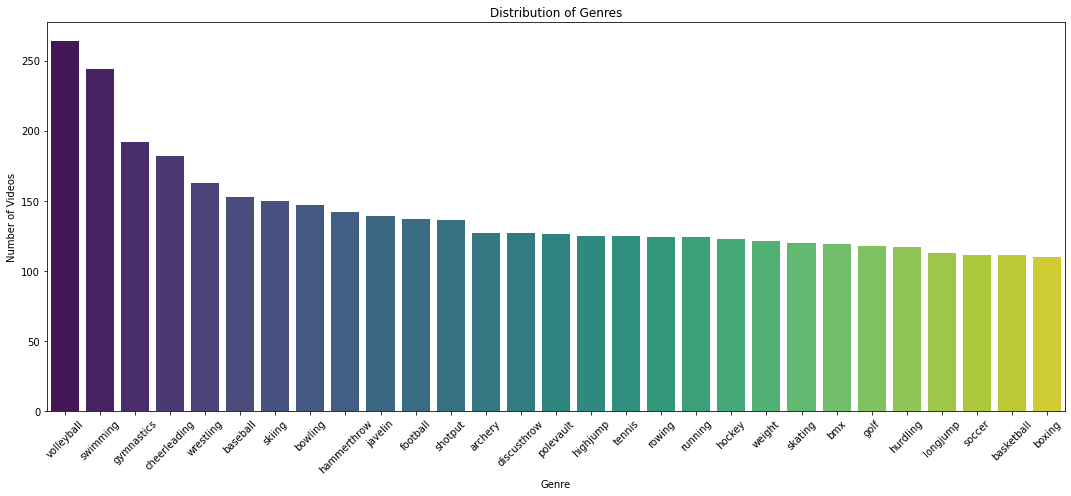

In [17]:
# Load metadata without filtering by train/test split for a comprehensive analysis
all_data_metadata = pd.read_csv(os.path.join(BASE_DIR, "SVW.csv"))
all_data_metadata = all_data_metadata.dropna(subset=['Genre'])

# Count the number of videos for each genre
genre_counts = all_data_metadata['Genre'].value_counts()

# Plot
plt.figure(figsize=(15,7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title("Distribution of Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

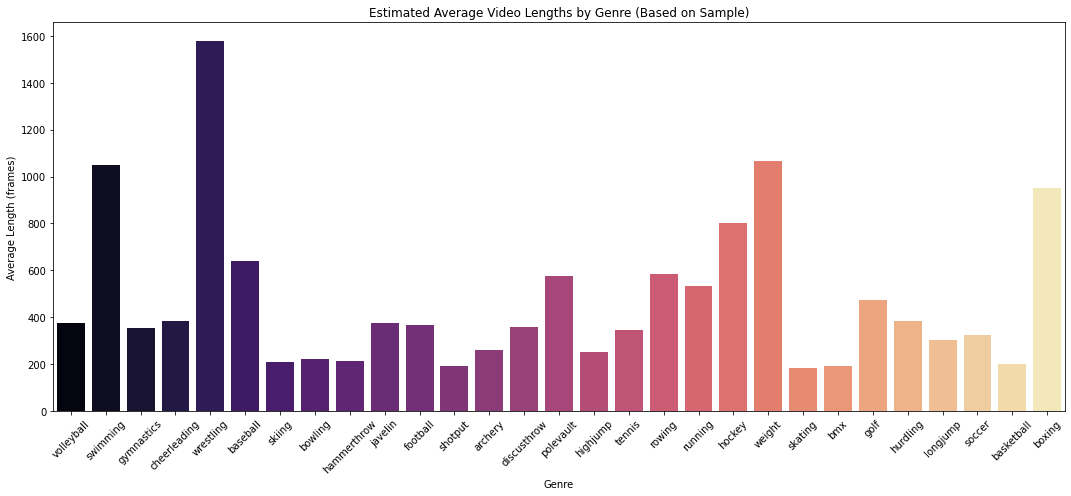

In [18]:
def average_video_length_sample(genre, sample_size=5):
    # Randomly sample a subset of videos for the given genre
    genre_videos = all_data_metadata[all_data_metadata['Genre'] == genre].sample(sample_size)
    
    lengths = []
    for _, row in genre_videos.iterrows():
        video_path = os.path.join(BASE_DIR, "Videos", row['Genre'], row['FileName'])

        cap = cv2.VideoCapture(video_path)

        # Check if the video was opened successfully
        if not cap.isOpened():
            print("Failed to open video:", video_path)
            continue
        
        lengths.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        cap.release()

    return sum(lengths) / len(lengths) if lengths else 0

genre_avg_lengths_sample = {genre: average_video_length_sample(genre) for genre in genre_counts.index}

# Plot
plt.figure(figsize=(15,7))
sns.barplot(x=list(genre_avg_lengths_sample.keys()), y=list(genre_avg_lengths_sample.values()), palette="magma")
plt.title("Estimated Average Video Lengths by Genre (Based on Sample)")
plt.xlabel("Genre")
plt.ylabel("Average Length (frames)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


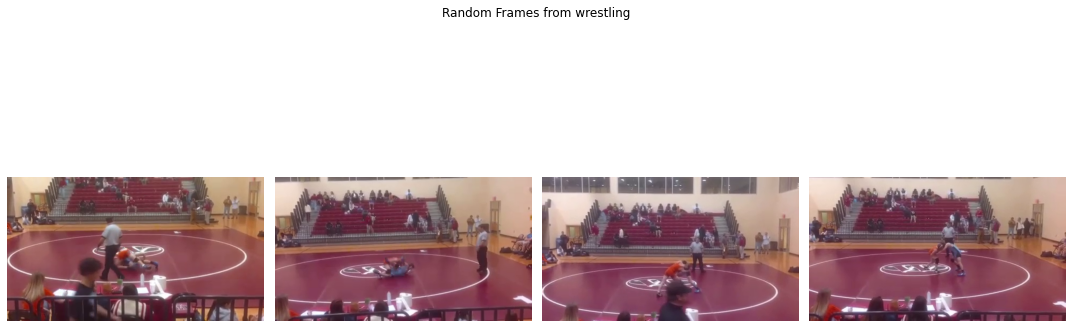

In [19]:
def show_frames_from_random_video(genre):
    sample_video = random.choice(all_data_metadata[all_data_metadata['Genre'] == genre]['FileName'].tolist())
    cap = cv2.VideoCapture(os.path.join(BASE_DIR, "Videos",  genre, sample_video))
    
    # Display 4 random frames from the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    chosen_frames = random.sample(range(0, total_frames), 4)
    
    plt.figure(figsize=(15,7))
    
    for i, frame_num in enumerate(chosen_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 4, i+1)
        plt.imshow(frame)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle(f"Random Frames from {genre}")
    plt.show()
    cap.release()

# Show frames from a random genre
show_frames_from_random_video(random.choice(all_data_metadata['Genre'].unique()))


In [ ]:
# Hyperparameters & Device
lr = 0.001
batch_size = 16
num_epochs = 10
num_classes = len(train_data.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Dataset & Dataloader
train_data = SVWDataset(data_path=os.path.join(BASE_DIR, "Videos"), csv_file="SVW.csv", transform=transform, train_split=1, train1_or_test0 = 1)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)

# Model
model = r3d_18(weights="DEFAULT")  # Load a pretrained 3D ResNet-18
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting the final layer
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Permute the tensor dimensions
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Changing [batch, clip_length, C, H, W] to [batch, C, clip_length, H, W]
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if True:  # Print every 10 batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

print("Finished Training!")

In [ ]:
torch.save(model, 'model.pt')

In [22]:
test_data = SVWDataset(data_path=os.path.join(BASE_DIR, "Videos"), csv_file="SVW.csv", transform=transform, train_split=1, train1_or_test0 = 0)  # Set to train on all data not in split 1 (since this is training data)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

# Evaluate the model
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No gradients needed during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Permute the tensor dimensions as we did during training
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Changing [batch, clip_length, C, H, W] to [batch, C, clip_length, H, W]
        
        # Forward pass
        outputs = model(inputs)
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        
        # Update counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test videos: {accuracy:.2f}%')



Accuracy of the model on the test videos: 68.26%


RuntimeError: Given groups=1, weight of size [64, 3, 3, 7, 7], expected input[16, 16, 3, 224, 224] to have 3 channels, but got 16 channels instead

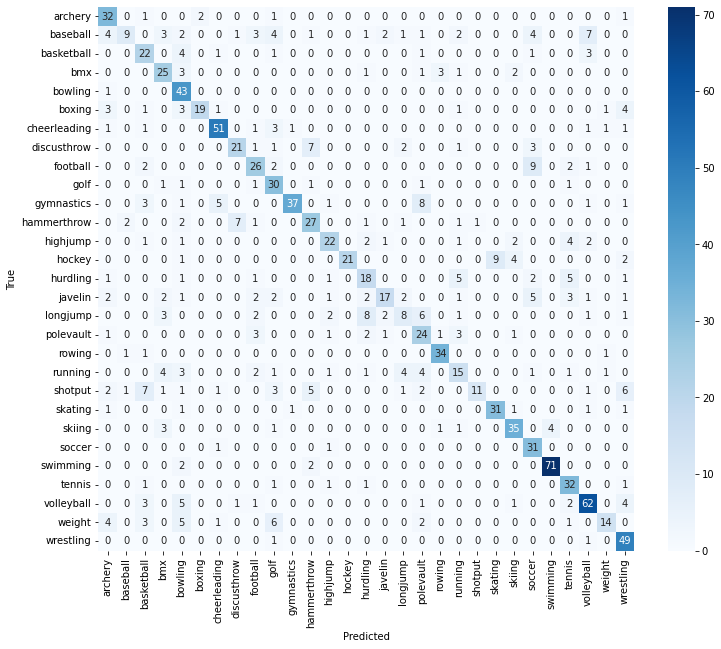

              precision    recall  f1-score   support

     archery       0.62      0.86      0.72        37
    baseball       0.69      0.20      0.31        45
  basketball       0.48      0.67      0.56        33
         bmx       0.60      0.69      0.64        36
     bowling       0.54      0.98      0.69        44
      boxing       0.90      0.58      0.70        33
cheerleading       0.84      0.84      0.84        61
 discusthrow       0.70      0.58      0.64        36
    football       0.59      0.62      0.60        42
        golf       0.53      0.83      0.65        36
  gymnastics       0.95      0.65      0.77        57
 hammerthrow       0.63      0.63      0.63        43
    highjump       0.71      0.61      0.66        36
      hockey       1.00      0.57      0.72        37
    hurdling       0.49      0.51      0.50        35
     javelin       0.74      0.40      0.52        42
    longjump       0.42      0.24      0.30        34
   polevault       0.47    

In [25]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1, 3, 4)  # Changing [batch, clip_length, C, H, W] to [batch, C, clip_length, H, W]
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # get the class with the highest score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate precision, recall, and F1 score
report = classification_report(all_labels, all_preds, target_names=train_data.classes)
print(report)